In [1]:
import json
import requests
import pandas as pd
import geopandas as gpd
import matplotlib
import numpy as np

from pandas.io.json import json_normalize
from shapely.geometry import Point, Polygon

# Количество станций

Референс Яндекса на список всех станций: https://yandex.ru/dev/rasp/doc/reference/stations-list-docpage/

Получим json со всеми станциями.

In [2]:
lang = 'ru_RU'
format = 'json'
url_base = 'https://api.rasp.yandex.net/v3.0/'
api_key = '3d4db511-c803-4569-a638-e0babb6cbccc'
url = (url_base + 'stations_list/?' + 'apikey=' + api_key +
       '&lang=' + lang +
       '&format=' + format
      )

In [3]:
r = requests.get(url)
r_json = r.json()

In [4]:
r_json['countries'][1]

{'regions': [{'settlements': [{'title': 'Банжул',
     'codes': {'yandex_code': 'c21012'},
     'stations': [{'direction': '',
       'codes': {'yandex_code': 's9628059'},
       'station_type': 'airport',
       'title': 'Юндум',
       'longitude': -16.652222,
       'transport_type': 'plane',
       'latitude': 13.338056}]}],
   'codes': {},
   'title': ''}],
 'codes': {'yandex_code': 'l21010'},
 'title': 'Гамбия'}

Положим json в датафрейм regions_data.

Оставим нужные нам поля:
- все поля для stations,
- название страны,
- название региона,
- название поселения,
- яндекс-код поселения.

In [5]:
regions_data = json_normalize(
    data=r_json['countries'],
    record_path=['regions', 'settlements', 'stations'],
    meta=['title',
         ['regions', 'title'],
         ['regions', 'settlements', 'title'],
         ['regions', 'settlements', 'codes', 'yandex_code'],
         ],
    errors='ignore',
    record_prefix='record_',
    meta_prefix='country_',
    sep='.'
)
regions_data.head(5)

,record_direction,record_station_type,record_title,record_longitude,record_transport_type,record_latitude,record_codes.yandex_code,record_codes.esr_code,country_title,country_regions.title,country_regions.settlements.title,country_regions.settlements.codes.yandex_code
0,,airport,Бермуды,-64.6787,plane,32.364,s9628674,NaN,Бермудские острова,,,NaN
1,,airport,Юндум,-16.6522,plane,13.3381,s9628059,NaN,Гамбия,,Банжул,c21012
2,,airport,Улей,168.3,plane,-16.3333,s9626301,NaN,Вануату,,Улей,c37074
3,,airport,Крейг-Коув,167.917,plane,-16.2667,s9624448,NaN,Вануату,,Крейг-Коув,c37075
4,,airport,Танна,169.224,plane,-19.455,s9626086,NaN,Вануату,,Танна,c37076


Переименуем столбцы.

In [6]:
regions_data.columns = ['station_direction',
                        'station_type',
                        'station_name',
                        'station_lon',
                        'transport_type',
                        'station_lat',
                        'station_yandex_code',
                        'station_esr_code',
                        'country',
                        'region',
                        'settlement_name',
                        'settlement_yandex_code'
                       ]

In [17]:
regions_data[regions_data['settlement_name'] == 'Москва'].head(5)

,station_direction,station_type,station_name,station_lon,transport_type,station_lat,station_yandex_code,station_esr_code,country,region,settlement_name,settlement_yandex_code
50582,Горьковское,train_station,Москва (Курский вокзал),37.660784,train,55.757383,s2000001,191602,Россия,Москва и Московская область,Москва,c213
50583,Ярославское,train_station,Москва (Ярославский вокзал),37.657484,train,55.777685,s2000002,195506,Россия,Москва и Московская область,Москва,c213
50584,Казанское,train_station,Москва (Казанский вокзал),37.657909,train,55.773941,s2000003,194013,Россия,Москва и Московская область,Москва,c213
50585,Павелецкое,train_station,Москва (Павелецкий вокзал),37.640771,train,55.729498,s2000005,193519,Россия,Москва и Московская область,Москва,c213
50586,Белорусское,train_station,Москва (Белорусский вокзал),37.580272,train,55.776764,s2000006,198230,Россия,Москва и Московская область,Москва,c213


Заменим пустые строки на NaN.

In [9]:
regions_data = regions_data.replace('', np.nan)

Интересно, что Я.Расписание к сетелменту Москва относит станции с 'transport_type': 'pseudo-gortrans' в Московской области. Например, удивительную станцию Бококо-Акулово в городском округе Озёры МО:

In [12]:
regions_data[regions_data['station_name'] == 'Бококо-Акулово']

,station_direction,station_type,station_name,station_lon,transport_type,station_lat,station_yandex_code,station_esr_code,country,region,settlement_name,settlement_yandex_code
53002,NaN,unknown,Бококо-Акулово,38.43516,pseudo-gortrans,54.993925,s9797383,NaN,Россия,Москва и Московская область,Москва,c213


Возможно, стоит взять границы Москвы и найти все станции в этих границах.

Возьму шейп Москвы из https://wambachers-osm.website/boundaries/

Шейпы:
- Moscow_AL4.shp - границы Москвы
- Moscow_AL5.shp - границы административных округов
- Moscow_AL8.shp - границы районов

In [13]:
%matplotlib inline
moscow_shape = gpd.read_file('msk_levels/Moscow_AL4.shp')
moscow_shape

,id,country,name,enname,locname,offname,boundary,adminlevel,wikidata,wikimedia,timestamp,note,rpath,ISO3166_2,geometry
0,102269,RUS,Moscow,Moscow,Москва,None,administrative,4,Q649,ru:Москва,2019-07-17 22:02:02,None,"102269,1029256,60189,0",RU-MOW,"(POLYGON ((36.8031012 55.4408329, 36.8031903 5..."


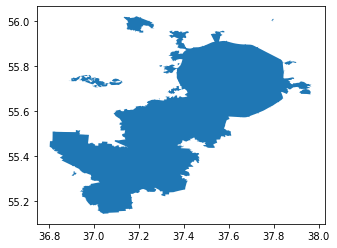

In [231]:
moscow_shape.plot()

Выглядит похоже. Переведем проекцию в Web Mercator (https://en.wikipedia.org/wiki/Web_Mercator_projection)

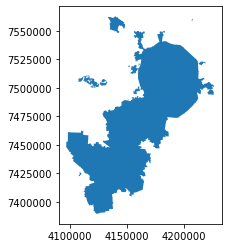

In [14]:
moscow_shape_wm = moscow_shape.to_crs({'init' :'epsg:3857'})
moscow_shape_wm.plot()

Добавим колонку про то, попадают ли координаты станции (если они есть) в границы Москвы.

In [18]:
in_moscow = (lambda row: moscow_shape.contains(Point(row.station_lon, row.station_lat)).bool())

In [19]:
regions_data['in_moscow'] = regions_data.apply(in_moscow, axis=1)

Посчитаем количество станций в границах Москвы:

In [24]:
stations_in_moscow_borders = regions_data[regions_data['in_moscow']].reset_index(drop=True)
len(stations_in_moscow_borders)

2532

Посчитаем станции, которые к Москве относит Я.Расписания:

In [25]:
stations_in_moscow_yandex = regions_data[regions_data['settlement_name'] == 'Москва'].reset_index(drop=True)
len(stations_in_moscow_yandex)

2884

Станции, которые Я относит к Москве, но которые находятся не там:

In [26]:
len(regions_data[(regions_data['settlement_name'] == 'Москва') & (~regions_data['in_moscow'])])

1810

И станции в пределах Москвы, которые Я отностит куда-то еще:

In [28]:
in_msk_not_listed = pd.DataFrame(regions_data[(regions_data['settlement_name'] != 'Москва') &
                                              (regions_data['in_moscow'])]
                                )
len(in_msk_not_listed)

1458

Посмотрим, куда отнёс их Я:

In [29]:
in_msk_not_listed['settlement_name'].unique()

array([nan, 'Казань', 'Пучково', 'Свитино (Клёновское с.п.)', 'Весенино',
       'Рогозинино', 'Первомайское', 'Знамя Октября', 'Акулово',
       'Аксиньино', 'Ватутинки', 'Подольск', 'Ватутинки, деревня',
       'Московский', 'Ботаково', 'Ширяево', 'Новые Ватутинки', 'Ерино',
       'Яковлевское', 'Кузнецово', 'Ямонтово', 'Сосенки', 'Рассказовка',
       'Долгопрудный', 'Зеленоград', 'Шарапово', 'Виноградово', 'Химки',
       'Косовка', 'Щербинка', 'Реутов', 'Мытищи', 'Гарнизона Остафьево',
       'Зосимова Пустынь', 'Верховье', 'Зверево', 'Киевский', 'Крёкшино',
       'ИЦ Сколково', 'Ульяновского лесопарка', 'Грибки', 'Мосрентген',
       'Коммунарка', 'Рассудово', 'Бекасово', 'Львово', 'Курилово',
       'Лукошкино', 'Кресты', 'Красная Пахра', 'Красное', 'Киселево',
       'Томилино', 'Юрьево', 'Новокурьяново', 'Переделкино', 'Рогово',
       'Починки', 'Остафьево', 'Ознобишино', 'Мешково', 'Михайловское',
       'Минзаг', 'Чириково (Кленовское с/п)',
       'Чириково (Краснопахорс

В Москву ходит псевдо-гортранс из Казани:

In [30]:
in_msk_not_listed[in_msk_not_listed['settlement_name'] == 'Казань'].head()

,station_direction,station_type,station_name,station_lon,transport_type,station_lat,station_yandex_code,station_esr_code,country,region,settlement_name,settlement_yandex_code,in_moscow
42797,NaN,unknown,"Микрорайон ""Град Московский""",37.373066,pseudo-gortrans,55.588073,s9776717,NaN,Россия,Республика Татарстан,Казань,c43,True
42798,NaN,unknown,"Метро ""Южная""",37.609582,pseudo-gortrans,55.622593,s9776733,NaN,Россия,Республика Татарстан,Казань,c43,True
42799,NaN,unknown,"Метро ""Пражская""",37.603730,pseudo-gortrans,55.612034,s9776734,NaN,Россия,Республика Татарстан,Казань,c43,True
42828,NaN,unknown,"Д/к ""Заречье""",37.920949,pseudo-gortrans,55.683278,s9780287,NaN,Россия,Республика Татарстан,Казань,c43,True
42838,NaN,unknown,Таможня,37.536467,pseudo-gortrans,55.511672,s9781102,NaN,Россия,Республика Татарстан,Казань,c43,True


API Яндес.Расписаний для Москвы дает данные о поездах, автобусах, псевдо-гортранс-автобусах (?) и самолетах.

In [32]:
stations_in_moscow_borders['transport_type'].unique()

array(['pseudo-gortrans', 'bus', 'train', 'plane'], dtype=object)

Интересно, что:
- в референсе (https://yandex.ru/dev/rasp/doc/reference/stations-list-docpage/) про псевдо-гортранс ничего не сказано

- нет типа транспорта для электричек, который есть в референсе - suburban

Поскольку задание про общественный транспорт в Москве, оставим автобусы, электрички, МЦК и псевдо-гортранс.

Типы станций в Москве:

In [34]:
stations_in_moscow_borders['station_type'].unique()

array(['unknown', 'bus_stop', 'train_station', 'airport', 'bus_station',
       'station', 'platform', nan, 'stop'], dtype=object)

# Расписание по станции

Референс: https://yandex.ru/dev/rasp/doc/reference/schedule-on-station-docpage/

Посмотрим, как API отдает расписание по станциям:

In [35]:
lang = 'ru_RU'
format = 'json'
url_base = 'https://api.rasp.yandex.net/v3.0/'
api_key = '3d4db511-c803-4569-a638-e0babb6cbccc'
station = 's9741948'
#station = 's9776859'
date = '2019-07-22'
limit = '159'

url = (url_base + 'schedule/?' +
       'apikey=' + api_key +
       '&station=' + station +
       '&lang=' + lang +
       '&format=' + format +
       '&date=' + date +
       '&limit=' + limit
      )

In [36]:
r = requests.get(url)
r_json = r.json()

Для некоторых станций, например s9776859, Я не находит расписания.

#  Список станций следования

Референс: https://yandex.ru/dev/rasp/doc/reference/list-stations-route-docpage/

Посмотрим, как API отдает список станций следования:

In [37]:
lang = 'ru_RU'
format = 'json'
url_base = 'https://api.rasp.yandex.net/v3.0/'
api_key = '3d4db511-c803-4569-a638-e0babb6cbccc'
uid = '3_0_9836831_4'
show_systems = 'yandex'

url = (url_base + 'thread/?' +
       'apikey=' + api_key +
       '&uid=' + uid +
       '&lang=' + lang +
       '&format=' + format +
       '&show_systems=' + show_systems
      )

r = requests.get(url)
r_json = r.json()

# Расписание между станциями

Референс: https://yandex.ru/dev/rasp/doc/reference/schedule-point-point-docpage/